# Modelagem dos Textos Descritivos das Empresas

Embeddings vão ser utilizados para montar um espaço vetorial com distãncias em relação às frases que qualificam os alvos, como listadas no exercício.

Em seguida, as empresas serão clusterizadas dentro desse espaço de uma forma que enfatize a diferença entre as descrições que estão no alvo da tarefa e as que não estão.

## 1. Setup

In [278]:
import pandas as pd
import nltk
import tensorflow_hub as hub
import numpy as np
from typing import Callable
from tqdm import tqdm
import string
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.colors
from sklearn.metrics import pairwise_distances

In [2]:
(nltk.download('stopwords'), nltk.download('punkt'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\julio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(True, True)

In [3]:
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

## 2. Aquisição dos Dados

In [4]:
data = pd.read_csv('Dados\\clean_data.csv')
data.head()

,Unnamed: 0,Index,Name,Description,Employees,Funding,City,Subcountry,Latitude,Longitude
0,0,1,fitin,fitin is the latest fit tech platform that pro...,1.0,NaN,toronto,ontario,43.70011,79.416300
1,1,2,quinditech,our services include independent collaborati...,10.0,NaN,montreal,quebec,45.50884,73.587810
2,2,3,botfirst,chatlanding is a digital chatbot platform wher...,1.0,NaN,toronto,ontario,43.70011,79.416300
3,3,4,ravver,ai powered army of health professionals in you...,1.0,NaN,quebec,quebec,46.82596,71.235223
4,4,5,stylify,stylify is a mobile platform that connects peo...,1.0,NaN,toronto,ontario,43.70011,79.416300


## 3. Engenharia de Features

A ideia é tomar as descrições das empresas e gerar blocos com um certo número de palavras e com intersecção, a partir dos quais uma distância possa ser calculada em relação a cada uma das frases que limitam o target.

Para a geração dos blocos, serão removidas stop-words, já que se está buscando apenas uma distância em espaço semântico, não sendo necessário gerar linguagem ou extrair significados complexos.

A intersecção entre os blocos terá o efeito de uma janela correndo sobre a descrição da empresa, ou seja: uma convolução sobre aquela descrição.

Uma vez de posse dos blocos e das distâncias, para cada descrição de empresa, os pares (bloco ; frase descritiva de target) com menor distância serão tomados e suas distâncias selecionadas como features.

O número de palavras contido em cada bloco, o tamanho da intersecção e o número de distâncias selecionadas como features para cada empresa serão hiperparãmetros. Uma outra escolha arbitrária será a do embedding a ser usado para cálculo das distâncias.

Com isso, espera-se criar um espaço semântico de dimensionalidade baixa, onde o posicionamento de cada empresa se dará a partir da presença ou não de blocos de texto que se assemelhem aos contidos nos textos que limitam o target (os textos dados na descrição do exercício).

Note-se que, em geral, espaços semânticos são construídos com dimensionalidade alta, mas isso se dá porque as combinações de proximidade e distanciamento na identificação do valor semântico de cada token em um corpus são mais facilmente construídas em um espaço de alta dimensionalidade. Aqui o que se pretente é apenas separar um conjunto muito pequeno de classes de significado e isso pode ser bem realizado (e muito mais facilmente visualizado) em um espaço vetorial de baixa dimensionalidade.

A hipótese aqui é a de que, após construído o espaço e posicionados os pontos representativos de cada descrição, empresas com descrições que possuam blocos semelhantes aos do target ficarão comprimidas na proximidade da origem do espaço semântico, enquanto que empresas com descrições que não contenham blocos semelhantes aos do target ficarão dispersas em um "halo externo", mais distante da origem.

A partir daí, um procedimento de clustering (ou mesmo a simples construção de um intervalo - um círculo em torno da origem cujo raio separa as empresas do target das que não são de interesse) pode ser usado e as empresas serão, então, separadas por ele.

Após separadas as empresas, pode-se avaliar a qualidade da separação através de um teste de hipótese onde H0 seja que a média das distâncias NÃO seja significativamente diferente entre as do halo e as do centro; H1 sendo o contrário.

Adicionalmente, uma amostra de cada lado pode ser tomada, identificand-se visualmente se cada elemento é ou não pertencente ao target, gerando um proxy de matriz de confusão.

### 3.1. Pré-processamento

In [5]:
remove = set(nltk.corpus.stopwords.words('english')).union(set(string.punctuation))
emphasize = set(['water', 'hydric', 'wastewater'])

In [6]:
def pre_process(description:str):
    tkn = nltk.tokenize.word_tokenize(description)

    filtered = [w + (' ' + w if w in emphasize else '') for w in tkn if w not in remove]

    result = ' '.join(filtered)

    return result

In [7]:
desc = 'This is a water system, that manages: hydric resourses including wastewater.'
pre_process(desc)

'This water water system manages hydric hydric resourses including wastewater wastewater'

In [8]:
data['PPDesc'] = data['Description'].apply(pre_process)

In [9]:
data.head(10)

,Unnamed: 0,Index,Name,Description,Employees,Funding,City,Subcountry,Latitude,Longitude,PPDesc
0,0,1,fitin,fitin is the latest fit tech platform that pro...,1.0,NaN,toronto,ontario,43.70011,79.416300,fitin latest fit tech platform provides profes...
1,1,2,quinditech,our services include independent collaborati...,10.0,NaN,montreal,quebec,45.50884,73.587810,services include independent collaborative ai ...
2,2,3,botfirst,chatlanding is a digital chatbot platform wher...,1.0,NaN,toronto,ontario,43.70011,79.416300,chatlanding digital chatbot platform make conv...
3,3,4,ravver,ai powered army of health professionals in you...,1.0,NaN,quebec,quebec,46.82596,71.235223,ai powered army health professionals pocket fe...
4,4,5,stylify,stylify is a mobile platform that connects peo...,1.0,NaN,toronto,ontario,43.70011,79.416300,stylify mobile platform connects people local ...
5,5,6,peloton technologies,peloton has developed a unique banking transac...,10.0,NaN,victoria,british columbia,48.43294,123.369300,peloton developed unique banking transaction p...
6,6,7,weave travels,weave is a web platform for travel companies. ...,1.0,NaN,toronto,ontario,43.70011,79.416300,weave web platform travel companies allows tou...
7,7,8,space york university,yspace supports early stage technology compani...,1.0,NaN,markham,ontario,43.86682,79.266300,yspace supports early stage technology compani...
8,8,9,glaucus.ai,glaucus.ai offers artificial intelligence for ...,1.0,NaN,montreal,quebec,45.50884,73.587810,glaucus.ai offers artificial intelligence ever...
9,9,10,magnifi,"magnifi is an mobile, on demand video consulti...",10.0,NaN,toronto,ontario,43.70011,79.416300,magnifi mobile demand video consulting marketp...


### 3.2. Setup da Formação do Espaço Semântico

In [10]:
# Essas são as expressões que definem (limitam, no sentido semântico) o target. Ênfase foi dada na palavra 'water' para garantir que a mesma seja determinante nas
limiter_expressions = [
    'solutions waste water water'
    ,'improve water water quality water water efficiency use'
    ,'water water contamination'
    ,'water water human consumption'
    ,'water water resources'
]

In [11]:
reference = use(limiter_expressions)

reference.shape

TensorShape([5, 512])

In [12]:
def distance(block, reference_embeddings):
    emb = use([block])

    min_dist = float('inf')
    for i in range(reference_embeddings.shape[0]):
        emb_ref = reference_embeddings[i,:]

        dist = np.linalg.norm(emb - emb_ref) # Usando distância Euclidiana em função de estarmos interessados na magnitude da distância.

        if dist < min_dist:
            min_dist = dist

    return min_dist


In [13]:
expr = ['solutions on waste and water', 'transportation management', 'water contamination', 'land contamination', 'hydric resources management']
[distance(e, reference) for e in expr]

[0.7895613, 1.2858443, 0.36531618, 0.87889045, 1.0742764]

In [14]:
def split_into_blocks(text:str, block_size:int, interesection:int):
    if interesection >= block_size:
        raise ValueError(f'A interseção ({interesection}) precisa ser menor que o tamanho do bloco ({block_size}).')

    words = text.split(' ')
    N = len(words)

    if N < 4:
        words += [' '] + ['aaa'] * (4 - N)
        N = 4

    if block_size > N:
        raise ValueError(f'O tamanho do bloco ({block_size}) precisa ser menor ou igual ao número de palavras da descrição ({N}).')

    step = block_size - interesection
    max_index = min(N - block_size + 1, N)
    convolution_map = [list(range(i, i + block_size)) for i in range(0, max_index , step)]

    blocks = []
    for m in convolution_map:
        block = ' '.join(words[i] for i in m)
        blocks.append(block)

    return blocks


In [15]:
tst = 'aaa bbb ccc ddd eee fff ggg hhh iii jjj'
split_into_blocks(tst, 3, 2)

['aaa bbb ccc',
 'bbb ccc ddd',
 'ccc ddd eee',
 'ddd eee fff',
 'eee fff ggg',
 'fff ggg hhh',
 'ggg hhh iii',
 'hhh iii jjj']

In [16]:
def update_min_values(value:float, min_values:list):
    mv = list(min_values)

    N = len(mv)
    for i in range(N):
        if value == mv[i]:
            break
        elif value < mv[i]:
            tmp = mv[i:N - 1]
            mv[i] = value
            mv[i + 1:N] = tmp

            break

    return mv

In [17]:
a = [6, 9, 12, 15]
b = 13

update_min_values(b, a)

[6, 9, 12, 13]

In [18]:
def stub_distance(block:str, reference_blocks): # Função destinada apenas a testar a convolução, sem depender das distâncias em si.
    return len(block)

In [19]:
a = 'asdfg'
stub_distance(a, reference)

5

In [20]:
def convolve_over_text(text:str, block_size:int, intersection:int, num_min_distances:int, reference_embeddings:np.array, distance_function:Callable):
    blocks = split_into_blocks(text, block_size, intersection)

    min_dist = [float('inf')] * num_min_distances

    for b in blocks:
        dist = distance_function(b, reference_embeddings)

        min_dist = update_min_values(dist, min_dist)

    return min_dist

In [21]:
txt = 'a b sd trft kl kkkk de w dd fffff'
convolve_over_text(txt, 3, 2, 2, reference, stub_distance)

[6, 7]

### 3.2. Formação do Espaço Semântico

Está sendo utilizado um espaço vetorial bidimensional, em primeiro lugar porque a tarefa assim o permite e, em segundo lugar, porque isso grandemente facilita a visualização e a explicabilidade do modelo e de seus resultados.

In [22]:
block_size = 3
intersection = 2
num_distances = 2

distances = []
for _, row in tqdm(data.iterrows(), total=len(data)):
    desc = row['PPDesc']

    minimum = convolve_over_text(desc, block_size, intersection, num_distances, reference, distance)

    distances.append(minimum)

100%|██████████| 21289/21289 [48:49<00:00,  7.27it/s]  


In [23]:
dists = np.array(distances)
dists.shape

(21289, 2)

In [24]:
d1 = dists[:,0].transpose()
d2 = dists[:,1].transpose()

In [137]:
data['Dist1'] = d1
data['Dist2'] = d2

In [395]:
radius = 1.3 # Definição arbitrária, mas baseada em inspeção visual nuvem de dados. APenas para auxílio à visualização.

data['DistFromOrigin'] = data['Dist1'] ** 2 + data['Dist2'] ** 2

unitary = data[data['DistFromOrigin'] <= radius]

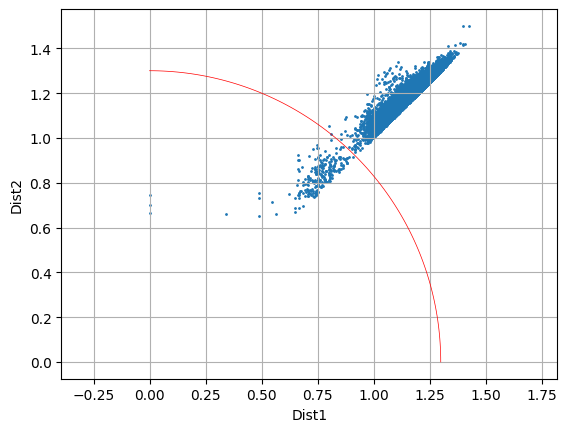

In [406]:
data.plot.scatter(x='Dist1', y='Dist2', s=1)

a1 = np.deg2rad(0)
a2 = np.deg2rad(90)

ang = np.linspace(a1, a2, 100)

x = radius * np.cos(ang)
y = radius * np.sin(ang)

plt.plot(x, y, color='red', linewidth=0.5)

plt.axis('equal')
plt.grid(True)

### 3.3. Separação do Espaço Semântico

Como a nuvem de pontos dentro do círculo acima é extremamente pouco densa em relação à nuvem fora do círculo, a clusterização orientada à separação semântica encontrada, se tentada por métodos como K-means, DBSCAN ou mesmo GMM, é muito desafiadora (...e o prazo para a entrega da prova está acabando, para ser sincero... :P ).

No entanto, como o espaço é de baixa dimensionalidade, a circunferência arbitrária acima pode servir como uma proxy de limite de cluster.

In [397]:
data['Labels'] = ['Out-of-Target'] * len(data)
data.loc[data['DistFromOrigin'] <= radius, 'Labels'] = 'Target'

In [398]:
(len(data[data['Labels'] == 'Target']), len(data[data['Labels'] != 'Target']))

(134, 21155)

In [399]:
target = data[data['Labels'] == 'Target']

In [400]:
len(target[target['Description'].str.contains('water')])

134

## 4. Gravação das Empresas Selecionadas

In [ ]:
data[data['Labels'] == 'Target'].to_csv('Dados\\target.csv')